# Pieces of code for my project

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from scipy.special import factorial, binom

plt.rcParams['text.usetex'] = True
        
cmap = cm.get_cmap('tab10')
color = [cmap(i) for i in range(10)]

In [54]:
def d_operator(f, x, r):
    if r==0:
        return f(x)
    else:
        eps = 1e-4
        return (d_operator(f, x+eps, r-1) - d_operator(f, x-eps, r-1))/(2*eps)

In [12]:
def bracket(ax, pos=[0,0], scalex=1, scaley=1, text="",textkw = {}, linekw = {}):
    x = np.array([0, 0.05, 0.45,0.5])
    y = np.array([0,-0.01,-0.01,-0.02])
    x = np.concatenate((x,x+0.5)) 
    y = np.concatenate((y,y[::-1]))
    ax.plot(x*scalex+pos[0], y*scaley+pos[1], clip_on=False, 
            transform=ax.get_xaxis_transform(), **linekw)
    ax.text(pos[0]+0.5*scalex, (y.min()-0.01)*scaley+pos[1], text, 
                transform=ax.get_xaxis_transform(),
                ha="center", va="top", **textkw)

# I. Polynomial interpolation

In [13]:
def PINT(TAU, oracle, X):
    """
    Parameters
    ----------
    TAU: array (n,)
        Values of the location parameter t 
    oracle: Class
        Custom class that allows to sample the g function and its derivatives
    X: array(m,)
        Locations at which the interpolated function is to be sampled
    Return 
    ---------
    F: array(m,)
        Values of the reconstructed function
    
    Method
    ------
    There exists a unique polynomial of order n (that is degree <= n-1) that
    agrees with g at t_1, ..., t_n
    In Newton form it is given by
            f(x) = \prod_{i=1}^n (x-t_1)...(x-t_{i-1})[t_1, ..., t_i]g
        
    """
    TAU = np.array(TAU)
    n = TAU.shape[0] 
    
    # Dictionary of divided difference of increasing order
    div_diff = {k: np.zeros(n-k) for k in range(n)}
    div_diff[0] = oracle.value(TAU)

    for k in range(1, n):
        for i in range(n-k):
            if TAU[i] == TAU[i+k]:
                div_diff[k][i] = oracle.derivative(TAU[i], k)
            else:
                div_diff[k][i] = (div_diff[k-1][i+1]-div_diff[k-1][i])/(TAU[i+k]-TAU[i])
    
    # Sample values of deriv reconstructed polynomial interpolation
    if not isinstance(X, np.ndarray):
        F = div_diff[0][0] + sum([np.prod(X-np.array(TAU)[:i])*div_diff[i][0] for i in range(1, n)])
        return F
    else:
        F = np.zeros(X.shape)
        for l, x in enumerate(X):
            F[l] = div_diff[0][0] + sum([np.prod(x-np.array(TAU)[:i])*div_diff[i][0] for i in range(1, n)])
        return F

### Some Oracles

In [66]:
class OracleSin(object):
    def __init__(self):
        pass
    def value(self, X):
        return np.sin(X)
    def derivative(self, X, r):
        if r%2 == 0:
            return (-1)**(r//2)*np.sin(X)
        else:
            return (-1)**((r)//2)*np.cos(X)
        
class OracleConst(object):
    def __init__(self):
        pass
    def value(self, X):
        if not isinstance(X, np.ndarray):
            return 1
        else:
            return np.array([1 for _ in X])
    def derivative(self, X, r):
        if r == 0:
            return self.value(X)
        else:
            if not isinstance(X, np.ndarray):
                return 0
            else:
                return np.array([0 for _ in X])
        
class OracleRunge(object):
    def __init__(self):
        pass
    def value(self, X):
        return 1/(1+25*X**2)
    def derivative(self, X, r):
        raise NotImplementedError
        
class OracleExpSin(object):
    def __init__(self):
        pass
    def value(self, X):
        return np.exp(X) + np.sin(X)
    def derivative(self, X, r):
        if r%2 == 0:
            return np.exp(X) + (-1)**(r//2)*np.sin(X)
        else:
            return np.exp(X) + (-1)**((r)//2)*np.cos(X)

### Example with exp + sinus function

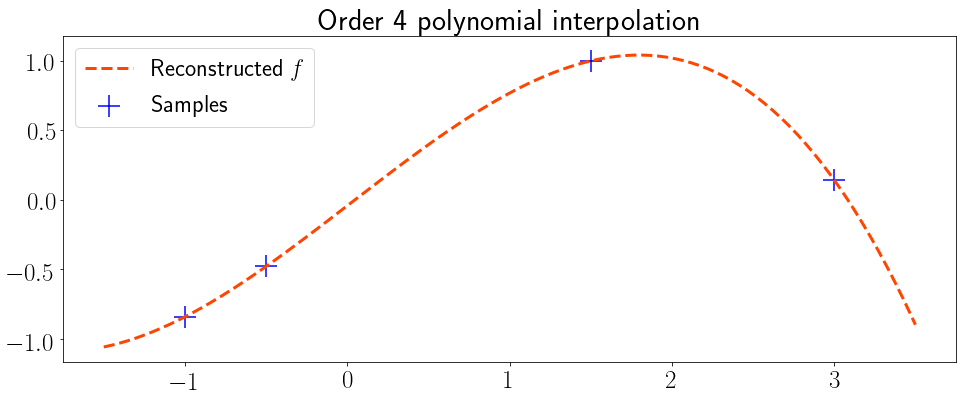

In [15]:
# TAU = np.array([-1, -0.5, 1.2, 1.5, 1.8, 3])
TAU = np.array([-1, -0.5, 1.5, 3])
X = np.linspace(TAU[0]-0.5, TAU[-1]+0.5, 200)
oracle = OracleSin()

        
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))
ax.plot(X, PINT(TAU, oracle, X), lw=3, color='orangered', ls= "--", label=r"Reconstructed $f$") # Reconstructed function f
ax.scatter(TAU, oracle.value(TAU), marker='+', s=450, color='blue', label="Samples") # Interpolated points

ax.tick_params(axis='both', labelsize=25)
ax.legend(loc='best', fontsize=24)

ax.set_title("Order %d polynomial interpolation" % (TAU.shape[0]), fontsize=30)
fig.savefig("../lab_meeting/presentation_1/lagrange_1.png")
plt.show()

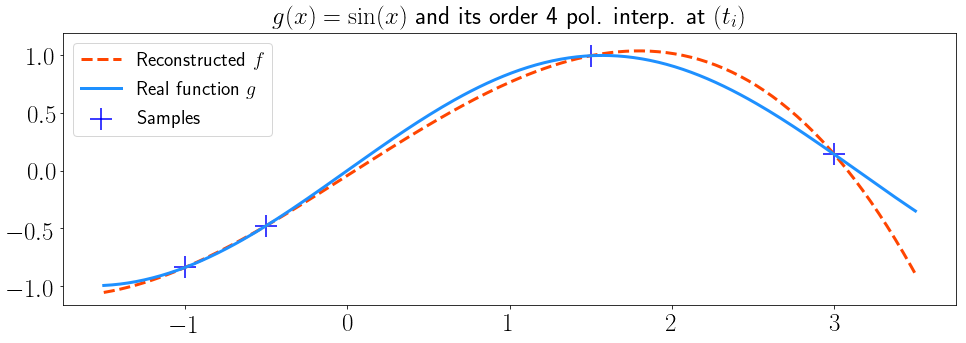

In [16]:
# TAU = np.array([-1, -0.5, 1.2, 1.5, 1.8, 3])
TAU = np.array([-1, -0.5, 1.5, 3])
X = np.linspace(TAU[0]-0.5, TAU[-1]+0.5, 200)
oracle = OracleSin()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 5))
ax.plot(X, PINT(TAU, oracle, X), lw=3, color='orangered', ls= "--", label=r"Reconstructed $f$") # Reconstructed function f
ax.plot(X, oracle.value(X), lw=3, color='dodgerblue', label=r"Real function $g$") # Real function
ax.scatter(TAU, oracle.value(TAU), marker='+', s=450, color='blue', label="Samples") # Interpolated points

ax.tick_params(axis='both', labelsize=25)
ax.legend(loc='best', fontsize=20)
 
ax.set_title(r"$g(x)= \sin(x)$ and its order %d pol. interp. at $(t_i)$" % (TAU.shape[0]), fontsize=25)
fig.savefig("../lab_meeting/presentation_1/lagrange_2.png")
plt.show()

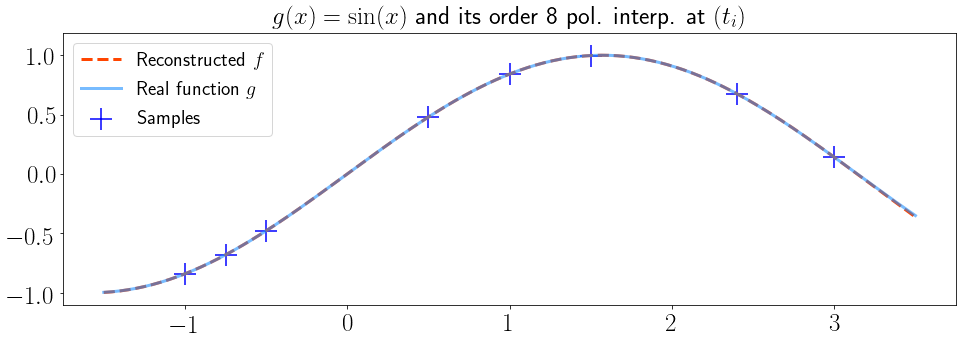

In [17]:
# TAU = np.array([-1, -0.5, 1.2, 1.5, 1.8, 3])
TAU = np.array([-1, -0.75, -0.5, 0.5, 1, 1.5, 2.4, 3])
X = np.linspace(TAU[0]-0.5, TAU[-1]+0.5, 200)
oracle = OracleSin()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 5))
ax.plot(X, PINT(TAU, oracle, X), lw=3, color='orangered', ls= "--", label=r"Reconstructed $f$") # Reconstructed function f
ax.plot(X, oracle.value(X), lw=3, color='dodgerblue', alpha=0.6, label=r"Real function $g$") # Real function
ax.scatter(TAU, oracle.value(TAU), marker='+', s=450, color='blue', label="Samples") # Interpolated points

ax.tick_params(axis='both', labelsize=25)
ax.legend(loc='best', fontsize=20)

ax.set_title(r"$g(x) = \sin(x)$ and its order %d pol. interp. at $(t_i)$" % (TAU.shape[0]), fontsize=25)
fig.savefig("../lab_meeting/presentation_1/lagrange_3.png")
plt.show()

### Runge example

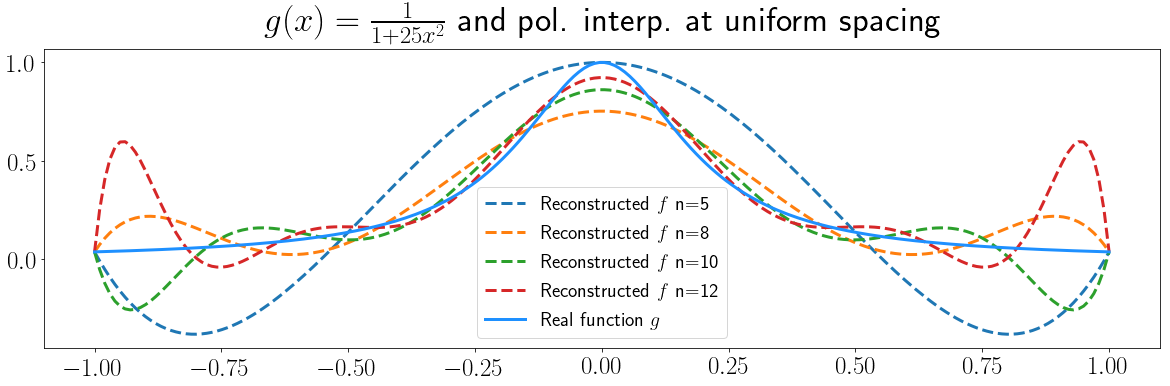

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5.5)) 
oracle = OracleRunge()

for c, n in zip(color, [5, 8, 10, 12]):
    TAU = np.linspace(-1, 1, n)
    X = np.linspace(TAU[0], TAU[-1], 200)
    ax.plot(X, PINT(TAU, oracle, X), lw=3, color=c, ls= "--", label=r"Reconstructed $f$ n=%d" % n) # Reconstructed function f

ax.plot(X, oracle.value(X), lw=3, color='dodgerblue', label=r"Real function $g$") # Real function
ax.tick_params(axis='both', labelsize=25)
ax.legend(loc='best', fontsize=20)

ax.set_title(r"$g(x) = \frac{1}{1+25x^2}$ and pol. interp. at uniform spacing", fontsize=35)
fig.savefig("../lab_meeting/presentation_1/runge_1.png")
plt.show()

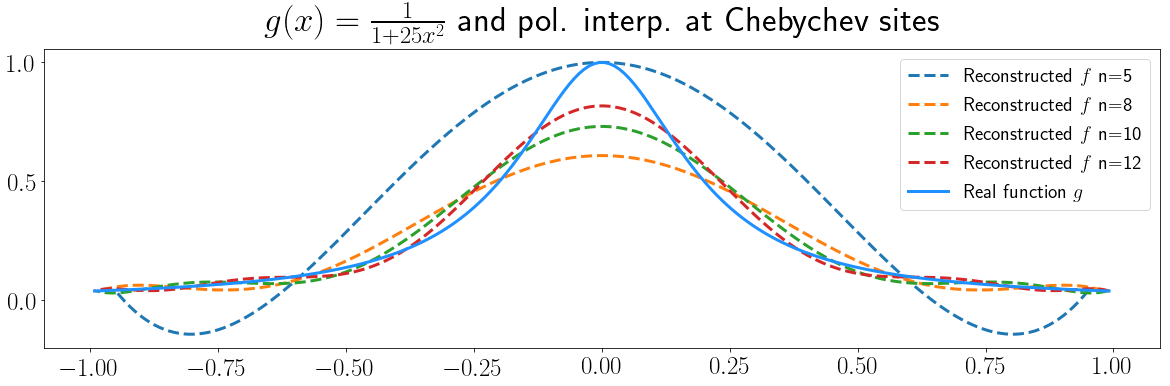

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5.5)) 
oracle = OracleRunge()

for c, n in zip(color, [5, 8, 10, 12]):
    TAU = np.zeros(n)
    for i in range(n):
        TAU[i] = np.cos((2*i+1)*np.pi/(2.*n)) # Chebychev sites
        
    X = np.linspace(TAU[0], TAU[-1], 200)
    ax.plot(X, PINT(TAU, oracle, X), lw=3, color=c, ls= "--", label=r"Reconstructed $f$ n=%d" % n) # Reconstructed function f

ax.plot(X, oracle.value(X), lw=3, color='dodgerblue', label=r"Real function $g$") # Real function
ax.tick_params(axis='both', labelsize=25)
ax.legend(loc='best', fontsize=20)

ax.set_title(r"$g(x) = \frac{1}{1+25x^2}$ and pol. interp. at Chebychev sites", fontsize=35)
fig.savefig("../lab_meeting/presentation_1/runge_2.png")
plt.show()

## II. Piecewise-polynomial interpolation

In [20]:
def quick_find(x, xt):
    lxt = len(xt)
    if lxt == 1:
        return 0
    else:
        if x < xt[lxt//2]:
            return quick_find(x, xt[:lxt//2])
        else:
            return lxt//2 + quick_find(x, xt[lxt//2:])

def interv(x, xt):
    """
    from  * a practical guide to splines *  by C. de Boor    

    Computes  left = max( i :  xt(i) .lt. xt(lxt) .and.  xt(i) .le. x )  .

    ******  i n p u t  ******
    x.....the point whose location with respect to the sequence  xt  is
            to be determined.
    xt.....a real sequence, of length  lxt , assumed to be nondecreasing

    ******  o u t p u t  ******
    left, mflag.....both integers, whose value is

    0     -1      if             x < xt[0]
    i      0      if   xt[i]  <= x < xt[i+1]
    i      0      if   xt[i]  <  x = xt[i+1] = xt[lxt-1]
    i      1      if   xt[i]  <      xt[i+1] = xt[lxt-1] < x

    In particular,  mflag = 0  is the 'usual' case.  mflag != 0 indicates that 
    x  lies outside the CLOSED interval xt[0] <= y <= xt[lxt-1] . The asymmetric 
    treatment of the intervals is due to the decision to make all pp functions 
    continuous from the right, but, by returning  mflag = 0  even if x = xt[lxt-1], 
    there is the option of having the computed pp function continuous from the left 
    at  xt[lxt-1].
    """
    lxt = len(xt)
    
    if x < xt[0]:
        return (0, -1)
    elif xt[lxt-1] < x:
        return (lxt-1, 1)
    else:
        return (quick_find(x, xt), 0)
    
def ppvalu(ptbreak, coef, x, jderiv):
    """
    from  * a practical guide to splines *  by c. de boor    
    calls  interv
    calculates value at  x  of  jderiv-th derivative of pp fct from pp-repr

    ******  i n p u t  ******
    break, coef, l, k.....forms the pp-representation of the function  f
        to be evaluated. specifically, the j-th derivative of  f  is
        given by

        coef[j, i] = (d**(j-1))f(ptbreak[i]^+)

    (d**j)f(x) = coef(j+1,i) + h*(coef(j+2,i) + h*( ... (coef(k-1,i) +
                             + h*coef(k,i)/(k-j-1))/(k-j-2) ... )/2)/1

        with  h = x - ptbreak[i],  and
        i=max(0, max(j,  ptbreak[j] <= x , 1 <= j <= l)).

    x.....the point at which to evaluate.
    jderiv.....integer giving the order of the derivative to be evaluat-
        ed.  assumed to be zero or positive.

    ******  o u t p u t  ******
      ppvalu.....the value of the (jderiv)-th derivative of  f  at  x.

    ******  m e t h o d  ******
    the interval index  i , appropriate for  x , is found through a
    call to  interv . the formula above for the  jderiv-th derivative
    of  f  is then evaluated (by nested multiplication).
    """
    ptbreak = np.array(ptbreak)
    coef = np.array(coef)
    k, l = coef.shape[0], coef.shape[1]-1
    
    ppvalu = 0.
    fmmjdr = k - jderiv
    if fmmjdr  <=  0.:
        # derivatives of order  k or higher are identically zero.
        ppvalu = 0.
    else:
        # find index  i  of largest breakpoint to the left of  x .
        i, ndummy = interv(x, ptbreak)
        h = x - ptbreak[i]
        m = k
        while fmmjdr > 0:
            ppvalu = (ppvalu/fmmjdr)*h + coef[m-1, i]
            m = m-1
            fmmjdr = fmmjdr - 1.
    return ppvalu

## II.1 Piecewise linear

### Piecewise linear sinus

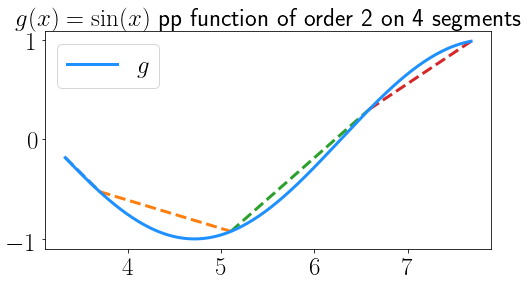

In [21]:
k = 2 # Piecewise order k polynomials
l = 4 # Number of segments
np.random.seed(23)
TAU = np.array(sorted(2 + np.random.rand(l+1)*6)) # l+1 irregularly spaced points
#TAU = np.linspace(2, 8, l+1) # l+1 regularly spaced points

oracle = OracleSin()
coef = np.zeros((k, l)) # coef[j,i] is the jth derivative at t_i^+ of the pp function

for i in range(l):
    coef[0, i] = oracle.value(TAU[i])
    coef[1, i] = (oracle.value(TAU[i+1])-oracle.value(TAU[i]))/(TAU[i+1]-TAU[i])
        
eps = 1e-6
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

# Display pp function on each segment
for i in range(l):
    X = np.linspace(TAU[i], TAU[i+1]-eps, 100)
    Y = [ppvalu(TAU, coef, x, 0) for x in X]
    ax.plot(X, Y, lw=3, ls='--', color=color[i])

X = np.linspace(TAU[0], TAU[-1], 200)    
ax.plot(X, oracle.value(X), lw=3, color='dodgerblue', label=r"$g$") # Real function
ax.tick_params(axis='both', labelsize=25)
ax.legend(loc='best', fontsize=25)

ax.set_title(r"$g(x) = \sin(x)$ pp function of order %d on %d segments" % (k, l), fontsize=25)
fig.savefig("../lab_meeting/presentation_1/pp_1.png")
plt.show()

### Representation with hat functions

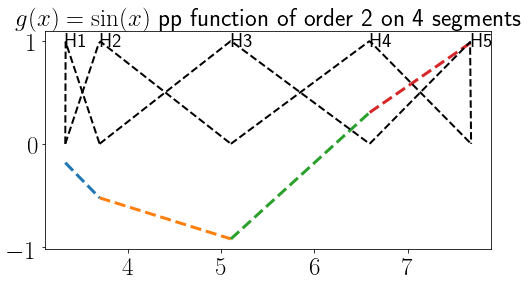

In [22]:
k = 2 # Piecewise order k polynomials
l = 4 # Number of segments 
np.random.seed(23)
TAU = np.array(sorted(2 + np.random.rand(l+1)*6)) # l+1 irregularly spaced points
#TAU = np.linspace(2, 8, l+1)  # l+1 regularly spaced points

def hat(t1, t2, t3, x):
    if t1 < x and x <= t2:
        return (x-t1)/(t2-t1)
    elif t2 < x and x < t3:
        return (t3-x)/(t3-t2)
    else:
        return 0
    

oracle = OracleSin()
coef = np.zeros((k, n-1)) # coef[j,i] is the jth derivative at t_i^+ of the pp function

# Fill coefficient values
for i in range(l):
    coef[0, i] = oracle.value(TAU[i])
    coef[1, i] = (oracle.value(TAU[i+1])-oracle.value(TAU[i]))/(TAU[i+1]-TAU[i])
        
eps = 1e-6
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

# Display pp function on each segment
for i in range(l):
    X = np.linspace(TAU[i], TAU[i+1]-eps, 100)
    Y = [ppvalu(TAU, coef, x, 0) for x in X]
    ax.plot(X, Y, lw=3, ls='--', color=color[i])
    
# Display hat functions
# l+1=n
for i in range(l+1):
    X = np.linspace(TAU[max(i-1, 0)], TAU[min(i+1, l)]+eps, 100)
    Y = [hat(TAU[max(i-1, 0)], TAU[i], TAU[min(i+1, l)], x) for x in X]
    ax.plot(X, Y, lw=2, ls='--', color='black')
    ax.annotate("H%d" % (i+1), size=20, xy=(TAU[i], 0.95))

# # Display the real function
# X = np.linspace(TAU[0], TAU[-1], 200)    
# ax.plot(X, oracle.value(X), lw=3, color='dodgerblue', label=r"Real function $g$") # Real function
# ax.legend(loc='best', fontsize=25)

ax.tick_params(axis='both', labelsize=25)
ax.set_title(r"$g(x) = \sin(x)$ pp function of order %d on %d segments" % (k, l), fontsize=25)
fig.savefig("../lab_meeting/presentation_1/pp_2.png")
plt.show()

## II.2 Piecewise cubic

### Piecewise cubic Hermite

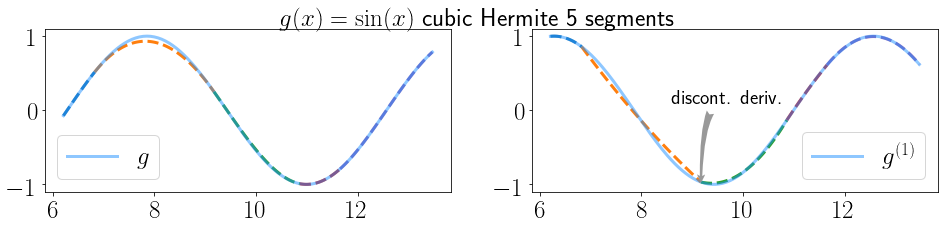

In [23]:
n = 6 # Number of points
np.random.seed(23)
TAU = np.array(sorted(4 + np.random.rand(n)*10)) # n irregularly spaced points
oracle = OracleSin()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 3))

# Display pp function on each segment
for i in range(n-1):
    X = np.linspace(TAU[i], TAU[i+1], 100)
    Y = PINT([TAU[i], TAU[i], TAU[i+1], TAU[i+1]], oracle, X)
    ax[0].plot(X, Y, lw=3, ls='--', color=color[i])

# Display real function
X = np.linspace(TAU[0], TAU[-1], 200)    
ax[0].plot(X, oracle.value(X), lw=3, color='dodgerblue', label=r"$g$", alpha=0.5) # Real function
ax[0].tick_params(axis='both', labelsize=25)
ax[0].legend(loc='best', fontsize=25)

# Display derivative pp function on each segment
for i in range(n-1):
    X = np.linspace(TAU[i], TAU[i+1], 100)
    Y = [d_operator(lambda z: PINT([TAU[i], TAU[i], TAU[i+1], TAU[i+1]], oracle, z), x, 1) for x in X]
    ax[1].plot(X, Y, lw=3, ls='--', color=color[i])

# Display real function derivative
X = np.linspace(TAU[0], TAU[-1], 200)    
ax[1].plot(X, [d_operator(lambda z: oracle.value(z), x, 1) for x in X], lw=3, color='dodgerblue', label=r"$g^{(1)}$", alpha=0.5) # Real function
ax[1].tick_params(axis='both', labelsize=25)
ax[1].legend(loc='best', fontsize=25)

ax[1].annotate('discont. deriv.',
            xy=(TAU[2], -1), xycoords='data',
            xytext=(-30, 80), textcoords='offset points',
            size=20,
            # bbox=dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.6", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=+90"))

plt.suptitle(r"$g(x) = \sin(x)$ cubic Hermite %d segments" % (n-1), fontsize=25)
fig.savefig("../lab_meeting/presentation_1/cubic_1.png")
plt.show()

In [ ]:
n = 6 # Number of points
np.random.seed(23)
TAU = np.array(sorted(4 + np.random.rand(n)*10)) # n irregularly spaced points
oracle = OracleSin()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 3))

# Display pp function on each segment
for i in range(n-1):
    X = np.linspace(TAU[i], TAU[i+1], 100)
    Y = PINT([TAU[i], TAU[i], TAU[i+1], TAU[i+1]], oracle, X)
    ax[0].plot(X, Y, lw=3, ls='--', color=color[i])

# Display real function
X = np.linspace(TAU[0], TAU[-1], 200)    
ax[0].plot(X, oracle.value(X), lw=3, color='dodgerblue', label=r"$g$", alpha=0.5) # Real function
ax[0].tick_params(axis='both', labelsize=25)
ax[0].legend(loc='best', fontsize=25)

# Display derivative pp function on each segment
for i in range(n-1):
    X = np.linspace(TAU[i], TAU[i+1], 100)
    Y = [d_operator(lambda z: PINT([TAU[i], TAU[i], TAU[i+1], TAU[i+1]], oracle, z), x, 1) for x in X]
    ax[1].plot(X, Y, lw=3, ls='--', color=color[i])

# Display real function derivative
X = np.linspace(TAU[0], TAU[-1], 200)    
ax[1].plot(X, [d_operator(lambda z: oracle.value(z), x, 1) for x in X], lw=3, color='dodgerblue', label=r"$g^{(1)}$", alpha=0.5) # Real function
ax[1].tick_params(axis='both', labelsize=25)
ax[1].legend(loc='best', fontsize=25)

ax[1].annotate('discont. deriv.',
            xy=(TAU[2], -1), xycoords='data',
            xytext=(-30, 80), textcoords='offset points',
            size=20,
            # bbox=dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.6", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=+90"))

plt.suptitle(r"$g(x) = \sin(x)$ cubic Hermite %d segments" % (n-1), fontsize=25)
fig.savefig("../lab_meeting/presentation_1/cubic_1.png")
plt.show()

### Complete cubic splines

In [24]:
def SHFTPOWER(coef, tau, x):
    return sum([c*(x-tau)**i for i,c in enumerate(coef)])

    def DIVDIF(TAU, oracle):
        TAU = np.array(TAU)
        n = TAU.shape[0] 

        # Dictionary of divided difference of increasing order
        div_dif = {k: np.zeros(n-k) for k in range(n)}
        div_dif[0] = oracle.value(TAU)

        for k in range(1, n):
            for i in range(n-k):
                if TAU[i] == TAU[i+k]:
                    div_dif[k][i] = oracle.derivative(TAU[i], k)
                else:
                    div_dif[k][i] = (div_dif[k-1][i+1]-div_dif[k-1][i])/(TAU[i+k]-TAU[i])
        return div_dif[n-1][0]

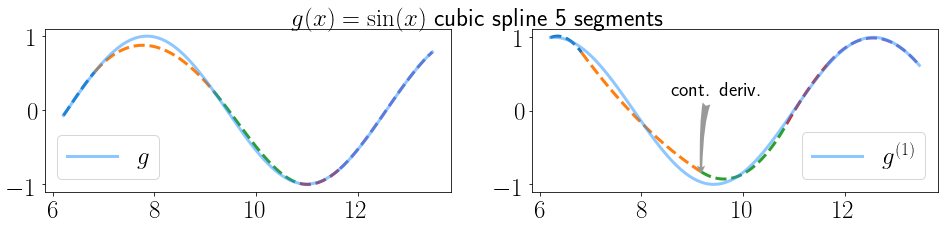

In [63]:
n = 6 # Number of points
np.random.seed(23)
TAU = np.array(sorted(4 + np.random.rand(n)*10)) # n irregularly spaced points
oracle = OracleSin()

# Slopes
S = np.zeros(n)
S[0] = oracle.derivative(TAU[0], 1)
S[-1] = oracle.derivative(TAU[-1], 1)

# Compute slopes that make interpolant C^2 continuous at breaks
A = np.zeros((n-2, n-2))
B = np.zeros(n-2)
for i in range(n-2):
    DTAU_i = TAU[i+2]-TAU[i+1]
    DTAU_im = TAU[i+1]-TAU[i]
    if i==0:
        A[i,i] = 2*(DTAU_i+DTAU_im)
        A[i,i+1] = DTAU_im
        B[i] = 3*((DTAU_i*DIVDIF(TAU[i:i+2], oracle) + DTAU_im*DIVDIF(TAU[i+1:i+3], oracle))) - S[i]*DTAU_i
    elif i==n-3:
        A[i,i-1] = DTAU_i
        A[i,i] = 2*(DTAU_i+DTAU_im)
        B[i] = 3*((DTAU_i*DIVDIF(TAU[i:i+2], oracle) + DTAU_im*DIVDIF(TAU[i+1:i+3], oracle))) - S[i+2]*DTAU_im
    else:
        A[i,i-1] = DTAU_i
        A[i,i] = 2*(DTAU_i+DTAU_im)
        A[i,i+1] = DTAU_im
        B[i] = 3*((DTAU_i*DIVDIF(TAU[i:i+2], oracle) + DTAU_im*DIVDIF(TAU[i+1:i+3], oracle)))
        
S[1:-1] = np.linalg.inv(A).dot(B)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 3))   

# Display pp function on each segment
for i in range(n-1):
    X = np.linspace(TAU[i], TAU[i+1], 100)
    DTAU_i = TAU[i+1]-TAU[i]
    c_1 = oracle.value(TAU[i])
    c_2 = S[i]
    c_4 = (S[i]+S[i+1]-2*DIVDIF(TAU[i:i+2], oracle))/DTAU_i**2
    c_3 = (DIVDIF(TAU[i:i+2], oracle)-S[i])/DTAU_i - c_4*DTAU_i
    coef = [c_1, c_2, c_3, c_4]
    Y = [SHFTPOWER(coef, TAU[i], x) for x in X]
    ax[0].plot(X, Y, lw=3, ls='--', color=color[i])

X = np.linspace(TAU[0], TAU[-1], 200)    
ax[0].plot(X, oracle.value(X), lw=3, color='dodgerblue', label=r"$g$", alpha=0.5) # Real function
ax[0].tick_params(axis='both', labelsize=25)
ax[0].legend(loc='best', fontsize=25)

# Display derivative pp function on each segment
for i in range(n-1):
    X = np.linspace(TAU[i], TAU[i+1], 100)
    DTAU_i = TAU[i+1]-TAU[i]
    c_1 = oracle.value(TAU[i])
    c_2 = S[i]
    c_4 = (S[i]+S[i+1]-2*DIVDIF(TAU[i:i+2], oracle))/DTAU_i**2
    c_3 = (DIVDIF(TAU[i:i+2], oracle)-S[i])/DTAU_i - c_4*DTAU_i
    coef = [c_1, c_2, c_3, c_4]
    Y = [d_operator(lambda z: SHFTPOWER(coef, TAU[i], z), x, 1) for x in X]
    ax[1].plot(X, Y, lw=3, ls='--', color=color[i])

X = np.linspace(TAU[0], TAU[-1], 200)    
ax[1].plot(X, [d_operator(lambda z: oracle.value(z), x, 1) for x in X], lw=3, color='dodgerblue', label=r"$g^{(1)}$", alpha=0.5) # Real function
ax[1].tick_params(axis='both', labelsize=25)
ax[1].legend(loc='best', fontsize=25)

ax[1].annotate('cont. deriv.',
            xy=(TAU[2], -0.88), xycoords='data',
            xytext=(-30, 80), textcoords='offset points',
            size=20,
            # bbox=dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.6", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=+90"))

plt.suptitle(r"$g(x) = \sin(x)$ cubic spline %d segments" % (n-1), fontsize=25)
fig.savefig("../lab_meeting/presentation_1/cubic_2.png")
plt.show()

### Cubic spline with NOT-A-KNOT CONDITION

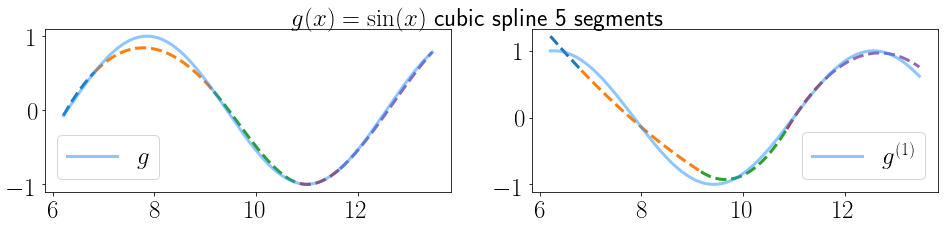

In [64]:
n = 6 # Number of points
np.random.seed(23)
TAU = np.array(sorted(4 + np.random.rand(n)*10)) # n irregularly spaced points
oracle = OracleSin()

# Slopes
S = np.zeros(n)

# Matrices for the system AS = B
A = np.zeros((n,n))
B = np.zeros(n)

# Equation for C^3 continuous at first interior break
A[0,0] = TAU[2]-TAU[1]
A[0,1] = TAU[2]-TAU[0]
B[0] = ((TAU[1]-TAU[0] + 2*(TAU[2]-TAU[0]))*(TAU[2]-TAU[1])*DIVDIF(TAU[0:2], oracle) + (TAU[1]-TAU[0])**2*DIVDIF(TAU[1:3], oracle))/(TAU[2]-TAU[0])

# Compute slopes that make interpolant C^2 continuous at n-2 interior breaks
for i in range(1, n-1):
    DTAU_i = TAU[i+1]-TAU[i]
    DTAU_im = TAU[i]-TAU[i-1]
    
    A[i,i-1] = DTAU_i
    A[i,i] = 2*(DTAU_i+DTAU_im)
    A[i,i+1] = DTAU_im
    B[i] = 3*((DTAU_i*DIVDIF(TAU[i-1:i+1], oracle) + DTAU_im*DIVDIF(TAU[i:i+2], oracle)))
    
# Equation for C^3 continuous at last interior break
A[-1,-2] = TAU[-1]-TAU[-3]
A[-1,-1] = TAU[-2]-TAU[-3]
B[-1] = ((TAU[-1]-TAU[-2])**2*DIVDIF(TAU[-3:-1], oracle) + (2*(TAU[-1]-TAU[-3]) + TAU[-1]-TAU[-2])*(TAU[-2]-TAU[-3])*DIVDIF(TAU[-2:], oracle))/(TAU[-1]-TAU[-3])
        
# Solve the system for S    
S = np.linalg.inv(A).dot(B)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 3))   

# Display pp function on each segment
for i in range(n-1):
    X = np.linspace(TAU[i], TAU[i+1], 100)
    DTAU_i = TAU[i+1]-TAU[i]
    c_1 = oracle.value(TAU[i])
    c_2 = S[i]
    c_4 = (S[i]+S[i+1]-2*DIVDIF(TAU[i:i+2], oracle))/DTAU_i**2
    c_3 = (DIVDIF(TAU[i:i+2], oracle)-S[i])/DTAU_i - c_4*DTAU_i
    coef = [c_1, c_2, c_3, c_4]
    Y = [SHFTPOWER(coef, TAU[i], x) for x in X]
    ax[0].plot(X, Y, lw=3, ls='--', color=cmap(i))

X = np.linspace(TAU[0], TAU[-1], 200)    
ax[0].plot(X, oracle.value(X), lw=3, color='dodgerblue', label=r"$g$", alpha=0.5) # Real function
ax[0].tick_params(axis='both', labelsize=25)
ax[0].legend(loc='best', fontsize=25)

# Display derivative pp function on each segment
for i in range(n-1):
    X = np.linspace(TAU[i], TAU[i+1], 100)
    DTAU_i = TAU[i+1]-TAU[i]
    c_1 = oracle.value(TAU[i])
    c_2 = S[i]
    c_4 = (S[i]+S[i+1]-2*DIVDIF(TAU[i:i+2], oracle))/DTAU_i**2
    c_3 = (DIVDIF(TAU[i:i+2], oracle)-S[i])/DTAU_i - c_4*DTAU_i
    coef = [c_1, c_2, c_3, c_4]
    Y = [d_operator(lambda z: SHFTPOWER(coef, TAU[i], z), x, 1) for x in X]
    ax[1].plot(X, Y, lw=3, ls='--', color=cmap(i))

X = np.linspace(TAU[0], TAU[-1], 200)    
ax[1].plot(X, [d_operator(lambda z: oracle.value(z), x, 1) for x in X], lw=3, color='dodgerblue', label=r"$g^{(1)}$", alpha=0.5) # Real function
ax[1].tick_params(axis='both', labelsize=25)
ax[1].legend(loc='best', fontsize=25)

plt.suptitle(r"$g(x) = \sin(x)$ cubic spline %d segments" % (n-1), fontsize=25)
# fig.savefig("../lab_meeting/presentation_1/cubic_3.png")
plt.show()

In [76]:
TAU = np.array([0.  , 0.25, 0.5 , 0.75, 1. ]) # n regularly spaced points
GTAU = np.array([0.00000000e+00, 1.11072073e+00, 1.57079633e+00, 1.11072073e+00, 1.92367069e-16])

class OracleDiscrete(object):
    def __init__(self, TAU, GTAU):
        self.TAU = np.array(TAU)
        self.GTAU = np.array(GTAU)
    def value(self, X):
        if not isinstance(X, np.ndarray):
            return self.GTAU[np.abs(self.TAU-X).argmin()]
        else:
            return np.array([self.GTAU[np.abs(self.TAU-x).argmin()] for x in X])
        
oracle = OracleDiscrete(TAU, GTAU)

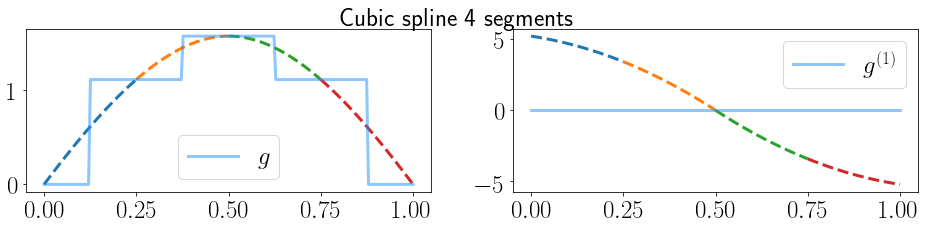

In [109]:
n = 5 # Number of points
np.random.seed(23)
TAU = np.array([0.  , 0.25, 0.5 , 0.75, 1. ]) # n regularly spaced points
GTAU = np.array([0.00000000e+00, 1.11072073e+00, 1.57079633e+00, 1.11072073e+00, 1.92367069e-16])

class OracleDiscrete(object):
    def __init__(self, TAU, GTAU):
        self.TAU = np.array(TAU)
        self.GTAU = np.array(GTAU)
    def value(self, X):
        if not isinstance(X, np.ndarray):
            return self.GTAU[np.abs(self.TAU-X).argmin()]
        else:
            return np.array([self.GTAU[np.abs(self.TAU-x).argmin()] for x in X])
        
oracle = OracleDiscrete(TAU, GTAU)

# Slopes
S = np.zeros(n)

# Matrices for the system AS = B
A = np.zeros((n,n))
B = np.zeros(n)

# Equation for C^3 continuous at first interior break
A[0,0] = TAU[2]-TAU[1]
A[0,1] = TAU[2]-TAU[0]
B[0] = ((TAU[1]-TAU[0] + 2*(TAU[2]-TAU[0]))*(TAU[2]-TAU[1])*DIVDIF(TAU[0:2], oracle) + (TAU[1]-TAU[0])**2*DIVDIF(TAU[1:3], oracle))/(TAU[2]-TAU[0])

# Compute slopes that make interpolant C^2 continuous at n-2 interior breaks
for i in range(1, n-1):
    DTAU_i = TAU[i+1]-TAU[i]
    DTAU_im = TAU[i]-TAU[i-1]
    
    A[i,i-1] = DTAU_i
    A[i,i] = 2*(DTAU_i+DTAU_im)
    A[i,i+1] = DTAU_im
    B[i] = 3*((DTAU_i*DIVDIF(TAU[i-1:i+1], oracle) + DTAU_im*DIVDIF(TAU[i:i+2], oracle)))
    
# Equation for C^3 continuous at last interior break
A[-1,-2] = TAU[-1]-TAU[-3]
A[-1,-1] = TAU[-2]-TAU[-3]
B[-1] = ((TAU[-1]-TAU[-2])**2*DIVDIF(TAU[-3:-1], oracle) + (2*(TAU[-1]-TAU[-3]) + TAU[-1]-TAU[-2])*(TAU[-2]-TAU[-3])*DIVDIF(TAU[-2:], oracle))/(TAU[-1]-TAU[-3])
        
# Solve the system for S    
S = np.linalg.inv(A).dot(B)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 3))   

# Display pp function on each segment
for i in range(n-1):
    X = np.linspace(TAU[i], TAU[i+1], 100)
    DTAU_i = TAU[i+1]-TAU[i]
    c_1 = oracle.value(TAU[i])
    c_2 = S[i]
    c_4 = (S[i]+S[i+1]-2*DIVDIF(TAU[i:i+2], oracle))/DTAU_i**2
    c_3 = (DIVDIF(TAU[i:i+2], oracle)-S[i])/DTAU_i - c_4*DTAU_i
    coef = [c_1, c_2, c_3, c_4]
    Y = [SHFTPOWER(coef, TAU[i], x) for x in X]
    ax[0].plot(X, Y, lw=3, ls='--', color=cmap(i))

X = np.linspace(TAU[0], TAU[-1], 200)    
ax[0].plot(X, oracle.value(X), lw=3, color='dodgerblue', label=r"$g$", alpha=0.5) # Real function
ax[0].tick_params(axis='both', labelsize=25)
ax[0].legend(loc='best', fontsize=25)

# Display derivative pp function on each segment
for i in range(n-1):
    X = np.linspace(TAU[i], TAU[i+1], 100)
    DTAU_i = TAU[i+1]-TAU[i]
    c_1 = oracle.value(TAU[i])
    c_2 = S[i]
    c_4 = (S[i]+S[i+1]-2*DIVDIF(TAU[i:i+2], oracle))/DTAU_i**2
    c_3 = (DIVDIF(TAU[i:i+2], oracle)-S[i])/DTAU_i - c_4*DTAU_i
    coef = [c_1, c_2, c_3, c_4]
    Y = [d_operator(lambda z: SHFTPOWER(coef, TAU[i], z), x, 1) for x in X]
    ax[1].plot(X, Y, lw=3, ls='--', color=cmap(i))

X = np.linspace(TAU[0], TAU[-1], 200)    
ax[1].plot(X, [d_operator(lambda z: oracle.value(z), x, 1) for x in X], lw=3, color='dodgerblue', label=r"$g^{(1)}$", alpha=0.5) # Real function
ax[1].tick_params(axis='both', labelsize=25)
ax[1].legend(loc='best', fontsize=25)

plt.suptitle(r"Cubic spline %d segments" % (n-1), fontsize=25)
# fig.savefig("../lab_meeting/presentation_1/cubic_3.png")
plt.show()

# III. B-splines

### De Boor

In [24]:
def quick_find(x, xt):
    lxt = len(xt)
    if lxt == 1:
        return 0
    else:
        if x < xt[lxt//2]:
            return quick_find(x, xt[:lxt//2])
        else:
            return lxt//2 + quick_find(x, xt[lxt//2:])
        
def BSPLVB_AUX(KNOTS, i, k, x):
    """
    Method
    ================
      The recurrence relation with t
    
                         x - t(j)                t(j+l) - x
         b(j,l)(x)  =  ----------- b(j,l-1)(x) + ---------------b(j+1,l-1)(x)
                      t(j+l-1)-t(j)              t(j+l)-t(j+1)
    
      is used (repeatedly) to generate the (k)-vector  b(i-k+1, k)(x),..., b(i,k)(x)
      and also the fact that
                b(j,1) = 1  if  t(j) <= x < t(j+1)
      and that
                b(j,l)(x) = 0  unless  t(j) <= x <  t(j+l)
      are used. 
    
    Returns
    =================
    BATX: np.array
        Contains b(i-k+1, k)(x), ...,  b(i, k)(x) for t(i) <= x < t(i+1)
    """
    KNOTS = np.array(KNOTS)
    
    assert KNOTS[i] <= x and x < KNOTS[i+1]
    assert i-k+1 >= 0
    assert i+k < KNOTS.shape[0]

    BATX = {l: np.zeros(l+2) for l in range(1, k+1)}
    
    # b(i, 1)(x)
    BATX[1][1] = 1
    
    def w(j, l, y):
        if KNOTS[j+l-1] == KNOTS[j]:
            return 0
        else:
            return (y-KNOTS[j])/(KNOTS[j+l-1]-KNOTS[j])
    
    for l in range(2, k+1):
        # BATX[l][0] = b(i-l, l)(x) = 0 and BATX[l][l+1] = b(i+1, l)(x) = 0
        for r in range(1, l+1):
            # Computes BATX[l][r] = b(i-l+r, l)(x)
            BATX[l][r] = w(i-l+r, l, x)*BATX[l-1][r-1] + (1-w(i-l+r+1, l, x))*BATX[l-1][r]
    return BATX[k][1:-1]

def BSPLVB(KNOTS, j, k, x):
    """
    Functions to compue b(j, k, x) for any x
    """
    i = quick_find(x, KNOTS)
    if i < j or i+1 > j+k:
        return 0
    else:
        return BSPLVB_AUX(KNOTS, i, k, x)[j+k-1-i]

## Examples order 1

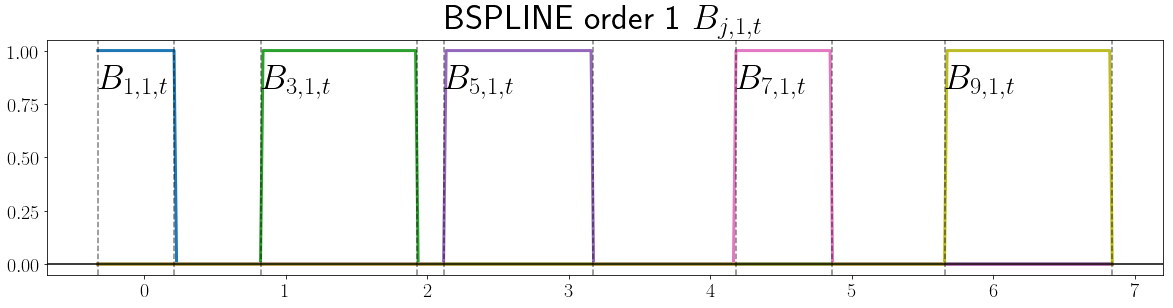

In [189]:
n = 10
k = 1

np.random.seed(23)
# KNOTS = np.linspace(-k, n+k, n+2*k+1) # n regularly spaced points
KNOTS = np.array(sorted(-2 + np.random.rand(n+2*k+1)*10)) # n irregularly spaced points
X = np.linspace(KNOTS[k], KNOTS[n+k-1], 400)


# Display jth B-spline of order k i.e B-spline with support in (KNOTS[j+k], KNOTS[j+2*k])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4.5))
for j in range(0, n-k, 2):
    Y = [BSPLVB(KNOTS, j+k, k, x) for x in X]
    ax.plot(X, Y, lw=3, color=color[j])
    ax.annotate(r"$B_{%d, %d, t}$" % (j+1, k), size=35, xy=(KNOTS[j+3*k//2], 0.8*BSPLVB(KNOTS, j+k, k, KNOTS[j+3*k//2])))

# Display knots locations
for x in KNOTS[k:n+k]:
    ax.axvline(x, color='black', ls='--', alpha=0.5)
    
# Display x-axis
ax.axhline(0, color='black', ls='-')

ax.tick_params(axis='both', labelsize=20)
title = r"BSPLINE order %d $B_{j, %d, t}$" % (k, k)    
ax.set_title(title, fontsize=35)
 
plt.subplots_adjust(top=0.85)
fig.savefig("../lab_meeting/presentation_1/bspline_order_1.png")
plt.show(fig)

## Examples order 2

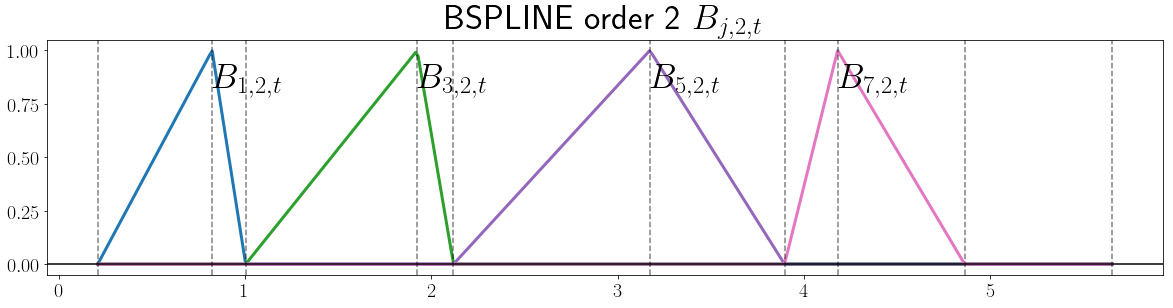

In [190]:
n = 10
k = 2

np.random.seed(23)
# KNOTS = np.linspace(-k, n+k, n+2*k+1) # n regularly spaced points
KNOTS = np.array(sorted(-2 + np.random.rand(n+2*k+1)*10)) # n irregularly spaced points
X = np.linspace(KNOTS[k], KNOTS[n+k-1], 400)


# Display jth B-spline of order k i.e B-spline with support in (KNOTS[j+k], KNOTS[j+2*k])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4.5))
for j in range(0, n-k, 2):
    Y = [BSPLVB(KNOTS, j+k, k, x) for x in X]
    ax.plot(X, Y, lw=3, color=color[j])
    ax.annotate(r"$B_{%d, %d, t}$" % (j+1, k), size=35, xy=(KNOTS[j+3*k//2], 0.8*BSPLVB(KNOTS, j+k, k, KNOTS[j+3*k//2])))

# Display knots locations
for x in KNOTS[k:n+k]:
    ax.axvline(x, color='black', ls='--', alpha=0.5)
    
# Display x-axis
ax.axhline(0, color='black', ls='-')
        
ax.tick_params(axis='both', labelsize=20)
title = r"BSPLINE order %d $B_{j, %d, t}$ " % (k, k)    
ax.set_title(title, fontsize=35)
    
plt.subplots_adjust(top=0.85)
fig.savefig("../lab_meeting/presentation_1/bspline_order_2.png")
plt.show(fig)

## Examples order 3

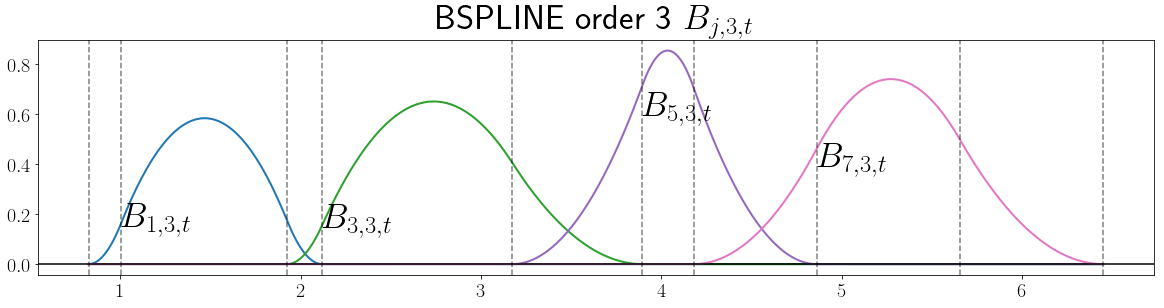

In [192]:
n = 10
k = 3

np.random.seed(23)
# KNOTS = np.linspace(-k, n+k, n+2*k+1) # n regularly spaced points
KNOTS = np.array(sorted(-2 + np.random.rand(n+2*k+1)*10)) # n irregularly spaced points
X = np.linspace(KNOTS[k], KNOTS[n+k-1], 400)


# Display jth B-spline of order k i.e B-spline with support in (KNOTS[j+k], KNOTS[j+2*k])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4.5))
for j in range(0, n-k, 2):
    Y = [BSPLVB(KNOTS, j+k, k, x) for x in X]
    ax.plot(X, Y, lw=2, color=color[j])
    ax.annotate(r"$B_{%d, %d, t}$" % (j+1, k), size=35, xy=(KNOTS[j+3*k//2], 0.8*BSPLVB(KNOTS, j+k, k, KNOTS[j+3*k//2])))

# Display knots locations
for x in KNOTS[k:n+k]:
    ax.axvline(x, color='black', ls='--', alpha=0.5)
    
# Display x-axis
ax.axhline(0, color='black', ls='-')
        
ax.tick_params(axis='both', labelsize=20)
title = r"BSPLINE order %d $B_{j, %d, t}$" % (k, k)    
ax.set_title(title, fontsize=35)
    
plt.subplots_adjust(top=0.85)
fig.savefig("../lab_meeting/presentation_1/bspline_order_3.png")
plt.show(fig)

## Example multiple knots

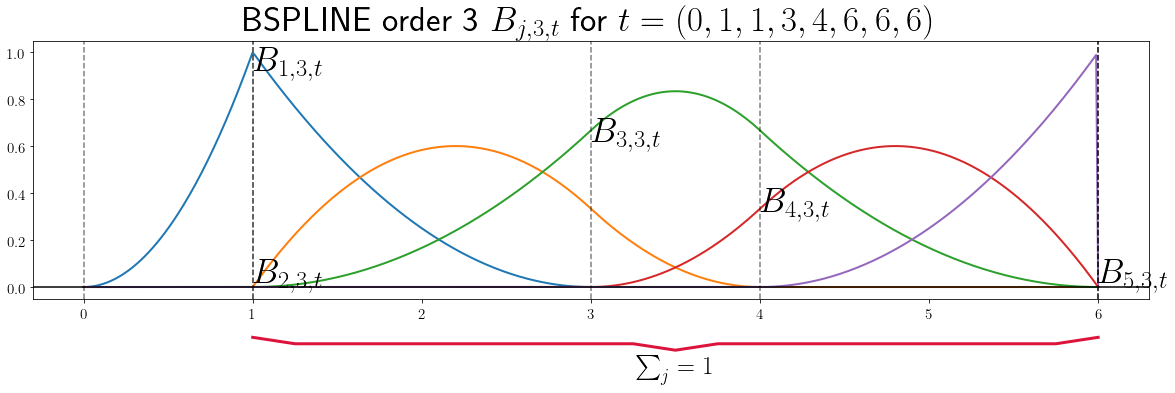

In [196]:
n = 8
k = 3

np.random.seed(23)
KNOTS = [-3, -2, -1, 0, 1, 1, 3, 4, 6, 6, 6, 7, 8, 9, 10]

#KNOTS = np.linspace(-k, n+k, n+2*k+1) # n regularly spaced points
#KNOTS = np.array(sorted(-2 + np.random.rand(n+2*k+1)*10)) # n irregularly spaced points
X = np.linspace(KNOTS[k], KNOTS[n+k-1], 500)


# Display jth B-spline of order k i.e B-spline with support in (KNOTS[j+k], KNOTS[j+2*k])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 6.5))
for j in range(n-k):
    Y = [BSPLVB(KNOTS, j+k, k, x) for x in X]
    ax.plot(X, Y, lw=2, color=color[j])
    ax.annotate(r"$B_{%d, %d, t}$" % (j+1, k), size=35, xy=(KNOTS[j+3*k//2], 0.90*BSPLVB(KNOTS, j+k, k, KNOTS[j+3*k//2])))

# Display knots locations
for x in KNOTS[k:n+k]:
    ax.axvline(x, color='black', ls='--', alpha=0.5)
    
# Display x-axis
ax.axhline(0, color='black', ls='-')

bracket(ax, text=r"$\sum_j = 1$", pos=[KNOTS[2*k-1], -0.15], scalex=KNOTS[n+k-1]-KNOTS[2*k-1], textkw=dict(size='25'), scaley=2.5, linekw=dict(color="crimson", lw=3) )
        
ax.tick_params(axis='both', labelsize=15)
title = r"BSPLINE order %d $B_{j, %d, t}$ for $t=(0,1,1,3,4,6,6,6)$" % (k, k)    
ax.set_title(title, fontsize=35)
    
plt.subplots_adjust(top=0.85)
plt.subplots_adjust(bottom=0.3)
fig.savefig("../lab_meeting/presentation_1/bspline_mult.png")
plt.show(fig)

### Cardinal splines

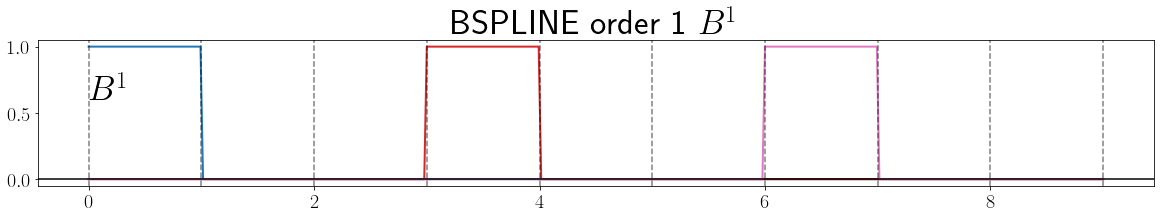

In [199]:
n = 10
k = 1

np.random.seed(23)
KNOTS = np.linspace(-k, n+k, n+2*k+1) # n regularly spaced points
X = np.linspace(KNOTS[k], KNOTS[n+k-1], 400)


# Display jth B-spline of order k i.e B-spline with support in (KNOTS[j+k], KNOTS[j+2*k])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))
for j in range(0, n-k, 3):
    Y = [BSPLVB(KNOTS, j+k, k, x) for x in X]
    ax.plot(X, Y, lw=2, color=color[j])
    if j==0:
        ax.annotate(r"$B^{%d}$" % (k), size=35, xy=(KNOTS[j+3*k//2], 0.6*BSPLVB(KNOTS, j+k, k, KNOTS[j+3*k//2])))

# Display knots locations
for x in KNOTS[k:n+k]:
    ax.axvline(x, color='black', ls='--', alpha=0.5)
    
# Display x-axis
ax.axhline(0, color='black', ls='-')
        
ax.tick_params(axis='both', labelsize=20)
title = r"BSPLINE order %d $B^{%d}$" % (k,k)  
ax.set_title(title, fontsize=35)
    
plt.subplots_adjust(top=0.8)
fig.savefig("../lab_meeting/presentation_1/card_order_1.png")
plt.show(fig)

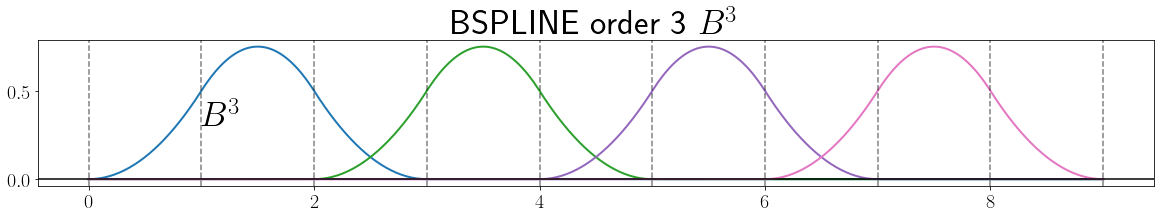

In [200]:
n = 10
k = 3

np.random.seed(23)
KNOTS = np.linspace(-k, n+k, n+2*k+1) # n regularly spaced points
X = np.linspace(KNOTS[k], KNOTS[n+k-1], 400)


# Display jth B-spline of order k i.e B-spline with support in (KNOTS[j+k], KNOTS[j+2*k])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))
for j in range(0, n-k, 2):
    Y = [BSPLVB(KNOTS, j+k, k, x) for x in X]
    ax.plot(X, Y, lw=2, color=color[j])
    if j==0:
        ax.annotate(r"$B^{%d}$" % (k), size=35, xy=(KNOTS[j+3*k//2], 0.6*BSPLVB(KNOTS, j+k, k, KNOTS[j+3*k//2])))

# Display knots locations
for x in KNOTS[k:n+k]:
    ax.axvline(x, color='black', ls='--', alpha=0.5)
    
# Display x-axis
ax.axhline(0, color='black', ls='-')
        
ax.tick_params(axis='both', labelsize=20)
title = r"BSPLINE order %d $B^{%d}$" % (k,k)  
ax.set_title(title, fontsize=35)
    
plt.subplots_adjust(top=0.8)
fig.savefig("../lab_meeting/presentation_1/card_order_3.png")
plt.show(fig)

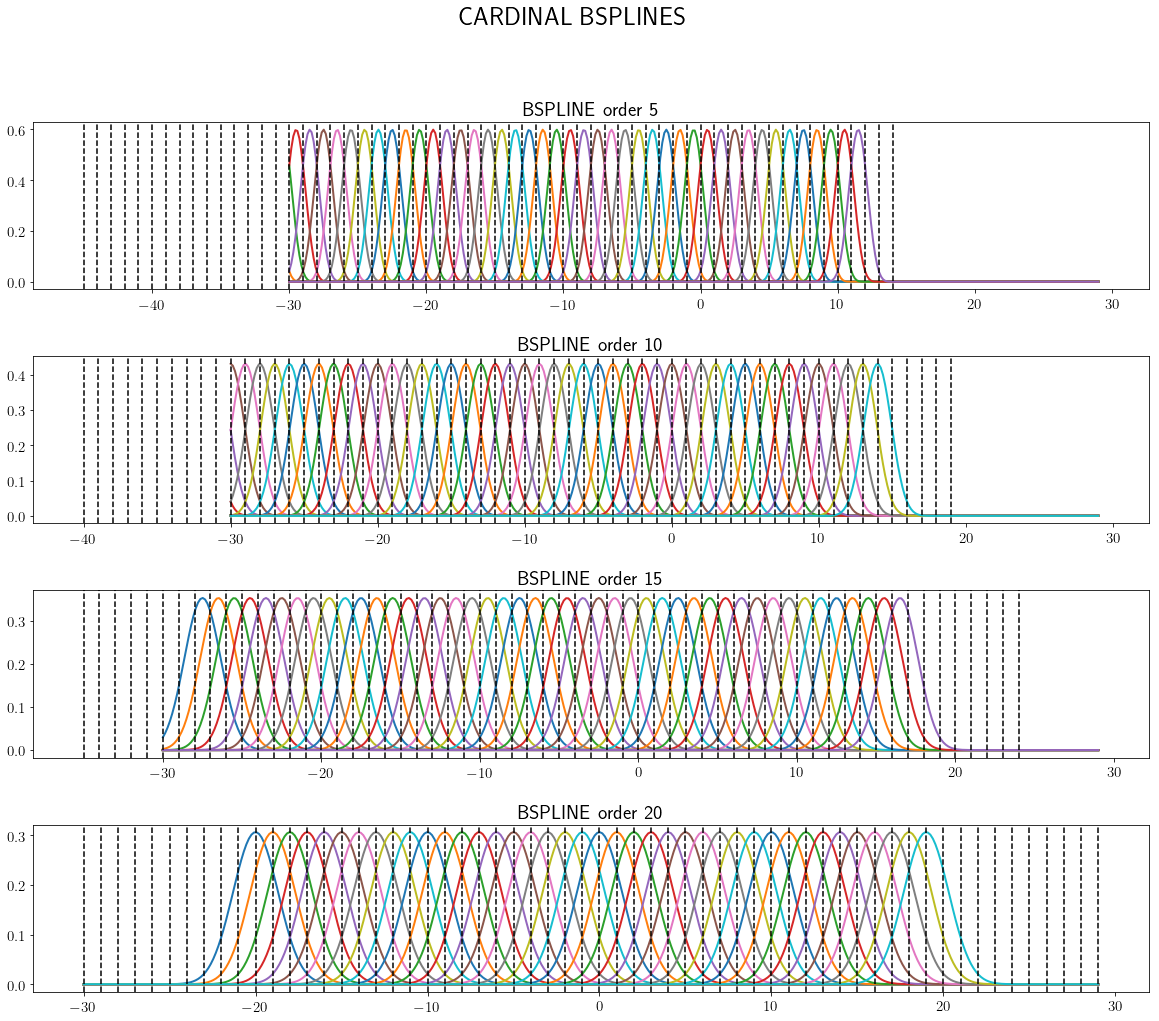

CPU times: user 5.85 s, sys: 23.8 ms, total: 5.87 s
Wall time: 5.9 s


In [115]:
%%time
n = 60

KNOTS = list(np.linspace(-n//2, n//2, n+1))
KNOTS = [KNOTS[0]-l for l in reversed(range(1, k+1))] + KNOTS + [KNOTS[-1]+l for l in range(1, k+1)] 
X = np.linspace(KNOTS[k], KNOTS[n+k-1], 400)

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(20, 4*4))
for i, k in zip(range(4), [5, 10, 15, 20]):
    for j in range(n-k): 
        Y = [BSPL(KNOTS, j+k, k, x) for x in X]
        ax[i].plot(X, Y, lw=2)
    ax[i].tick_params(axis='both', labelsize=15)
    for x in KNOTS[k:n+k]:
        ax[i].axvline(x, color='black', ls='--')
    ax[i].set_title("BSPLINE order %d" % k, fontsize=20)
    
plt.subplots_adjust(hspace=0.4)
plt.suptitle("CARDINAL BSPLINES", fontsize=25)
plt.show(fig)

## Cardinal B-splines

### De Boor

$$ B_{j,k}(x) = \sum_{r=0}^k (-1)^{k-r} \binom{k}{r} (r+k-x)_+^{k-1} $$

In [22]:
def TRPOWER(x, k):
    assert type(k)==int
    assert k >= 0
    if x <= 0:
        return 0
    else:
        return x**k

def CBSPL(j, k, x):
    """
    Returns the value of the jth B-spline of order on 
    integer knots
    """
    if k==0:
        if j<= x and x < j+1:
            return 1
        else:
            return 0
    else:
        return sum([(-1)**(k-r)*binom(k, r)*TRPOWER(j+r-x,k-1) for r in range(k+1)])/factorial(k)

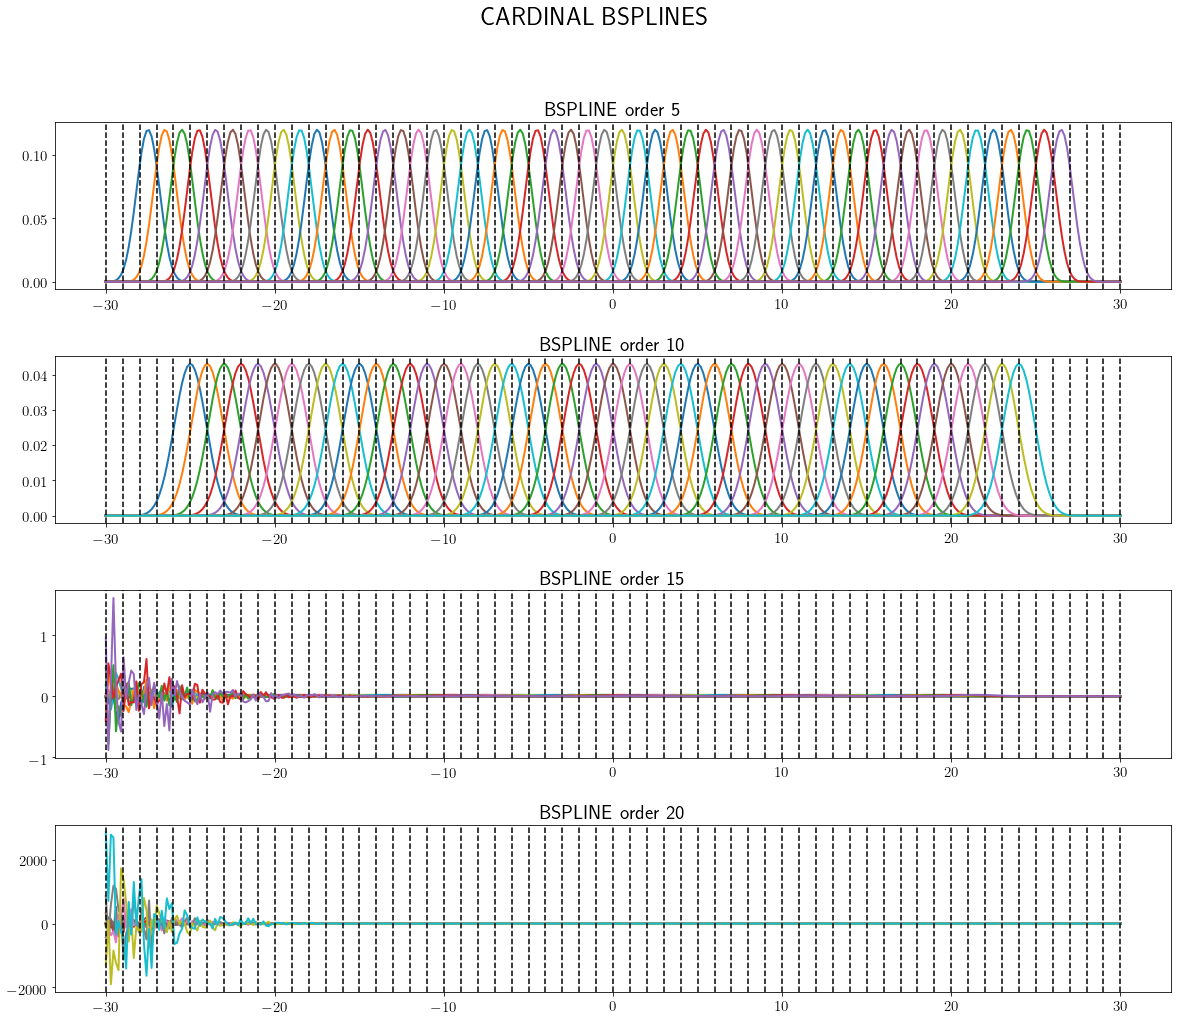

In [25]:
n = 30

KNOTS = np.linspace(-n, n, 2*n+1)
X = np.linspace(KNOTS[0], KNOTS[-1], 400)

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(20, 4*4))
for i, k in zip(range(4), [5, 10, 15, 20]):
    for j in range(-n, n-k):            
        Y = [CBSPL(j, k, x) for x in X]
        ax[i].plot(X, Y, lw=2)
    ax[i].tick_params(axis='both', labelsize=15)
    for x in KNOTS:
        ax[i].axvline(x, color='black', ls='--')
    ax[i].set_title("BSPLINE order %d" % k, fontsize=20)
    
plt.subplots_adjust(hspace=0.4)
plt.suptitle("CARDINAL BSPLINES", fontsize=25)
plt.show(fig)

## Unser 1999 "Splines: A perfect fit for signal and image processing"

\begin{equation}
\beta^0(x) = \begin{cases}
    1 &\text{if } -\frac{1}{2} < x < \frac{1}{2} \\
    0.5 &\text{if } |x| = \frac{1}{2} \\
    0  &\text{else }      
  \end{cases}
\end{equation}

\begin{equation}
    \beta^n = \beta^0 * \ldots * \beta^0 
\end{equation}

# IV. Twist estimation

In [138]:
def hphi_1(x):
    if 1 <= np.abs(x):
        return 0
    else:
        return 1 - 3*x**2 + 2*np.abs(x)**3
    
def hphi_2(x):
    if 1 <= np.abs(x):
        return 0
    else:
        if 0 <= x:
            return x - 2*x**2 + x**3
        else:
            return x + 2*x**2 + x**3
        
def dhphi_1(x):
    if 1 <= np.abs(x):
        return 0
    else:
        if 0 <= x:
            return - 6*x + 6*x**2
        else:
            return - 6*x - 6*x**2
    
def dhphi_2(x):
    if 1 <= np.abs(x):
        return 0
    else:
        if 0 <= x:
            return 1 - 4*x + 3*x**2
        else:
            return 1 + 4*x + 3*x**2
        
M = 5
c_1 = [0, 0.5, 0.25, 0.5, 0] # Values to interpolate
c_2 = [1, 0, 0, 0, -1] # Derivatives to interpolate

def func(v):
    assert 0 <= v and v <=1 
    return sum([c_1[k]*hphi_1((M-1)*v-k) + c_2[k]*hphi_2((M-1)*v-k) for k in range(M)])

def dfunc(v):
    assert 0 <= v and v <=1 
    return sum([c_1[k]*(M-1)*dhphi_1((M-1)*v-k) + c_2[k]*(M-1)*dhphi_2((M-1)*v-k) for k in range(M)])

In [139]:
M = 5
c_1 = [0, 0.5, 0.25, 0.5, 0] # Values to interpolate
c_2 = [1, 0, 0, 0, -1] # Derivatives to interpolate

def func(v):
    assert 0 <= v and v <=1 
    return sum([c_1[k]*hphi_1((M-1)*v-k) + c_2[k]*hphi_2((M-1)*v-k) for k in range(M)])

def dfunc(v):
    assert 0 <= v and v <=1 
    return sum([c_1[k]*(M-1)*dhphi_1((M-1)*v-k) + c_2[k]*(M-1)*dhphi_2((M-1)*v-k) for k in range(M)])

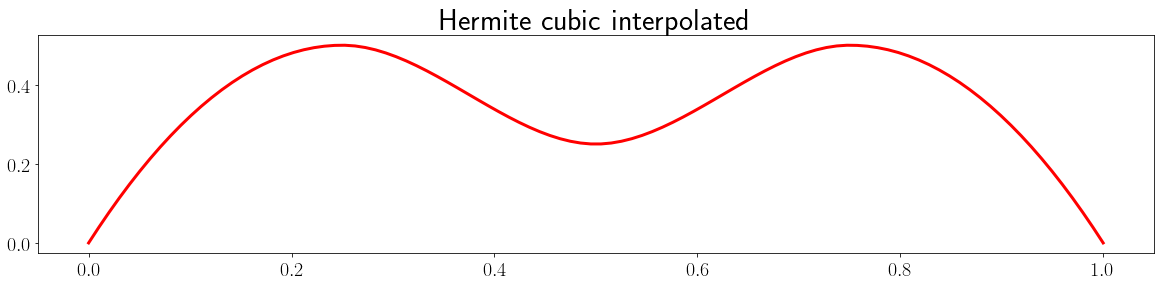

In [141]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
V = np.linspace(0, 1, 100)

ax.plot(V, [func(v) for v in V] , color='red', lw=3, label=r'$f$')
#ax.plot(V, [dfunc(v) for v in V] , color='red', ls='--', label=r'$f^{(1)}$')
ax.tick_params(axis='both', labelsize=20)
ax.set_title('Hermite cubic interpolated', fontsize=30)

plt.show(fig)

## IV. Naive twist estimation

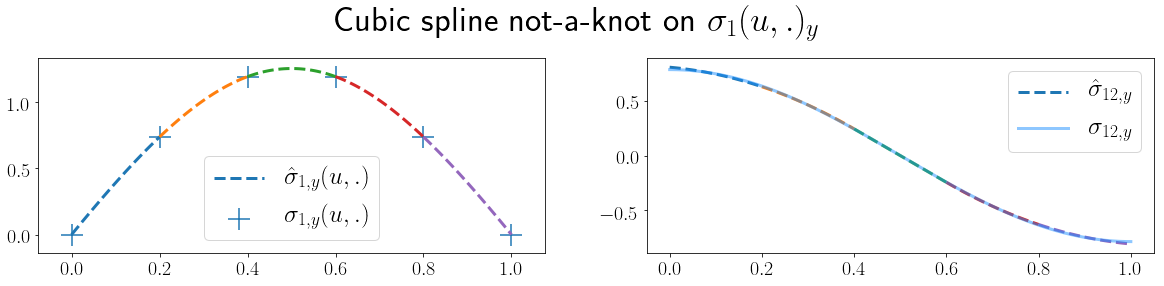

In [173]:
### y coordinates on first longitude for M_2 = 5

M_1 = 5
M_2 = 5
TAU = np.array([0., 0.2, 0.4, 0.6, 0.8, 1.]) # n regularly spaced points
GTAU = np.array([0, 0.739, 1.195, 1.195, 0.739, 0])

def g(v):
    u = 0
    return 2*np.pi**2*np.cos(2*np.pi*u)*np.cos(np.pi*v)/(M_1*M_2)

class OracleDiscrete(object):
    def __init__(self, TAU, GTAU):
        self.TAU = np.array(TAU)
        self.GTAU = np.array(GTAU)
    def value(self, X):
        if not isinstance(X, np.ndarray):
            return self.GTAU[np.abs(self.TAU-X).argmin()]
        else:
            return np.array([self.GTAU[np.abs(self.TAU-x).argmin()] for x in X])
        
oracle = OracleDiscrete(TAU, GTAU)
n = TAU.shape[0]

# Slopes
S = np.zeros(n)

# Matrices for the system AS = B
A = np.zeros((n,n))
B = np.zeros(n)

# Equation for C^3 continuous at first interior break
A[0,0] = TAU[2]-TAU[1]
A[0,1] = TAU[2]-TAU[0]
B[0] = ((TAU[1]-TAU[0] + 2*(TAU[2]-TAU[0]))*(TAU[2]-TAU[1])*DIVDIF(TAU[0:2], oracle) + (TAU[1]-TAU[0])**2*DIVDIF(TAU[1:3], oracle))/(TAU[2]-TAU[0])

# Compute slopes that make interpolant C^2 continuous at n-2 interior breaks
for i in range(1, n-1):
    DTAU_i = TAU[i+1]-TAU[i]
    DTAU_im = TAU[i]-TAU[i-1]
    
    A[i,i-1] = DTAU_i
    A[i,i] = 2*(DTAU_i+DTAU_im)
    A[i,i+1] = DTAU_im
    B[i] = 3*((DTAU_i*DIVDIF(TAU[i-1:i+1], oracle) + DTAU_im*DIVDIF(TAU[i:i+2], oracle)))
    
# Equation for C^3 continuous at last interior break
A[-1,-2] = TAU[-1]-TAU[-3]
A[-1,-1] = TAU[-2]-TAU[-3]
B[-1] = ((TAU[-1]-TAU[-2])**2*DIVDIF(TAU[-3:-1], oracle) + (2*(TAU[-1]-TAU[-3]) + TAU[-1]-TAU[-2])*(TAU[-2]-TAU[-3])*DIVDIF(TAU[-2:], oracle))/(TAU[-1]-TAU[-3])
        
# Solve the system for S    
S = np.linalg.inv(A).dot(B)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))   

# Display pp function on each segment
for i in range(n-1):
    X = np.linspace(TAU[i], TAU[i+1], 100)
    DTAU_i = TAU[i+1]-TAU[i]
    c_1 = oracle.value(TAU[i])
    c_2 = S[i]
    c_4 = (S[i]+S[i+1]-2*DIVDIF(TAU[i:i+2], oracle))/DTAU_i**2
    c_3 = (DIVDIF(TAU[i:i+2], oracle)-S[i])/DTAU_i - c_4*DTAU_i
    coef = [c_1, c_2, c_3, c_4]
    Y = [SHFTPOWER(coef, TAU[i], x) for x in X]
    if i==0:
        ax[0].plot(X, Y, lw=3, ls='--', color=cmap(i), label=r'$\hat{\sigma}_{1,y}(u, .)$')
    else:
        ax[0].plot(X, Y, lw=3, ls='--', color=cmap(i))
def r_12(u,v):
    return 2*np.pi**2*Point3D(-np.sin(2*np.pi*u)*np.cos(np.pi*v), np.cos(2*np.pi*u)*np.cos(np.pi*v),
                              0)/(snake.M_1*snake.M_2)

    
X = np.linspace(TAU[0], TAU[-1], 200)    
ax[0].scatter(TAU, GTAU, s=500, marker='+', label=r'$\sigma_{1,y}(u, .)$') # Real function
ax[0].tick_params(axis='both', labelsize=20)
ax[0].legend(loc='best', fontsize=25)

# Display derivative pp function on each segment
for i in range(n-1):
    X = np.linspace(TAU[i], TAU[i+1], 100)
    DTAU_i = TAU[i+1]-TAU[i]
    c_1 = oracle.value(TAU[i])
    c_2 = S[i]
    c_4 = (S[i]+S[i+1]-2*DIVDIF(TAU[i:i+2], oracle))/DTAU_i**2
    c_3 = (DIVDIF(TAU[i:i+2], oracle)-S[i])/DTAU_i - c_4*DTAU_i
    coef = [c_1, c_2, c_3, c_4]
    Y = [d_operator(lambda z: SHFTPOWER(coef, TAU[i], z), x, 1)/M_2 for x in X]
    if i==0:
        ax[1].plot(X, Y, lw=3, ls='--', color=cmap(i), label=r"$\hat{\sigma}_{12,y}$")
    else:
        ax[1].plot(X, Y, lw=3, ls='--', color=cmap(i))
        
X = np.linspace(TAU[0], TAU[-1], 200)    
ax[1].plot(X, g(X), lw=3, color='dodgerblue', label=r"$\sigma_{12,y}$", alpha=0.5) # Real function
ax[1].tick_params(axis='both', labelsize=20)
ax[1].legend(loc='best', fontsize=25)

plt.suptitle(r"Cubic spline not-a-knot on $\sigma_1(u,.)_y$", fontsize=35)
fig.subplots_adjust(top=0.8)
fig.savefig("../notes/twist/cubic_sigma_1.png")
plt.show()

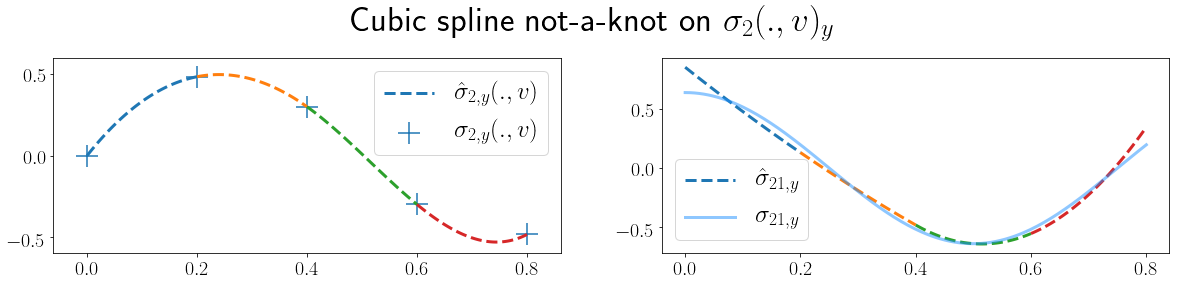

In [176]:
### y coordinates on second latitude (v=1) for M_2 = 5

M_1 = 5
M_2 = 5
TAU = np.array([0., 0.2, 0.4, 0.6, 0.8]) # n regularly spaced points
GTAU = np.array([0, 0.483, 0.299, -0.299, -0.483])

def g(u):
    v = 0.2
    return 2*np.pi**2*np.cos(2*np.pi*u)*np.cos(np.pi*v)/(M_1*M_2)


class OracleDiscrete(object):
    def __init__(self, TAU, GTAU):
        self.TAU = np.array(TAU)
        self.GTAU = np.array(GTAU)
    def value(self, X):
        if not isinstance(X, np.ndarray):
            return self.GTAU[np.abs(self.TAU-X).argmin()]
        else:
            return np.array([self.GTAU[np.abs(self.TAU-x).argmin()] for x in X])
        
oracle = OracleDiscrete(TAU, GTAU)
n = TAU.shape[0]

# Slopes
S = np.zeros(n)

# Matrices for the system AS = B
A = np.zeros((n,n))
B = np.zeros(n)

# Equation for C^3 continuous at first interior break
A[0,0] = TAU[2]-TAU[1]
A[0,1] = TAU[2]-TAU[0]
B[0] = ((TAU[1]-TAU[0] + 2*(TAU[2]-TAU[0]))*(TAU[2]-TAU[1])*DIVDIF(TAU[0:2], oracle) + (TAU[1]-TAU[0])**2*DIVDIF(TAU[1:3], oracle))/(TAU[2]-TAU[0])

# Compute slopes that make interpolant C^2 continuous at n-2 interior breaks
for i in range(1, n-1):
    DTAU_i = TAU[i+1]-TAU[i]
    DTAU_im = TAU[i]-TAU[i-1]
    
    A[i,i-1] = DTAU_i
    A[i,i] = 2*(DTAU_i+DTAU_im)
    A[i,i+1] = DTAU_im
    B[i] = 3*((DTAU_i*DIVDIF(TAU[i-1:i+1], oracle) + DTAU_im*DIVDIF(TAU[i:i+2], oracle)))
    
# Equation for C^3 continuous at last interior break
A[-1,-2] = TAU[-1]-TAU[-3]
A[-1,-1] = TAU[-2]-TAU[-3]
B[-1] = ((TAU[-1]-TAU[-2])**2*DIVDIF(TAU[-3:-1], oracle) + (2*(TAU[-1]-TAU[-3]) + TAU[-1]-TAU[-2])*(TAU[-2]-TAU[-3])*DIVDIF(TAU[-2:], oracle))/(TAU[-1]-TAU[-3])
        
# Solve the system for S    
S = np.linalg.inv(A).dot(B)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))   

# Display pp function on each segment
for i in range(n-1):
    X = np.linspace(TAU[i], TAU[i+1], 100)
    DTAU_i = TAU[i+1]-TAU[i]
    c_1 = oracle.value(TAU[i])
    c_2 = S[i]
    c_4 = (S[i]+S[i+1]-2*DIVDIF(TAU[i:i+2], oracle))/DTAU_i**2
    c_3 = (DIVDIF(TAU[i:i+2], oracle)-S[i])/DTAU_i - c_4*DTAU_i
    coef = [c_1, c_2, c_3, c_4]
    Y = [SHFTPOWER(coef, TAU[i], x) for x in X]
    if i==0:
        ax[0].plot(X, Y, lw=3, ls='--', color=cmap(i), label=r'$\hat{\sigma}_{2,y}(.,v)$')
    else:
        ax[0].plot(X, Y, lw=3, ls='--', color=cmap(i))
def r_12(u,v):
    return 2*np.pi**2*Point3D(-np.sin(2*np.pi*u)*np.cos(np.pi*v), np.cos(2*np.pi*u)*np.cos(np.pi*v),
                              0)/(snake.M_1*snake.M_2)

    
X = np.linspace(TAU[0], TAU[-1], 200)    
ax[0].scatter(TAU, GTAU, s=500, marker='+', label=r'$\sigma_{2,y}(.,v)$') # Real function
ax[0].tick_params(axis='both', labelsize=20)
ax[0].legend(loc='best', fontsize=25)

# Display derivative pp function on each segment
for i in range(n-1):
    X = np.linspace(TAU[i], TAU[i+1], 100)
    DTAU_i = TAU[i+1]-TAU[i]
    c_1 = oracle.value(TAU[i])
    c_2 = S[i]
    c_4 = (S[i]+S[i+1]-2*DIVDIF(TAU[i:i+2], oracle))/DTAU_i**2
    c_3 = (DIVDIF(TAU[i:i+2], oracle)-S[i])/DTAU_i - c_4*DTAU_i
    coef = [c_1, c_2, c_3, c_4]
    Y = [d_operator(lambda z: SHFTPOWER(coef, TAU[i], z), x, 1)/M_1 for x in X]
    if i==0:
        ax[1].plot(X, Y, lw=3, ls='--', color=cmap(i), label=r"$\hat{\sigma}_{21,y}$")
    else:
        ax[1].plot(X, Y, lw=3, ls='--', color=cmap(i))
        
X = np.linspace(TAU[0], TAU[-1], 200)    
ax[1].plot(X, g(X), lw=3, color='dodgerblue', label=r"$\sigma_{21,y}$", alpha=0.5) # Real function
ax[1].tick_params(axis='both', labelsize=20)
ax[1].legend(loc='best', fontsize=25)

plt.suptitle(r"Cubic spline not-a-knot on $\sigma_2(.,v)_y$", fontsize=35)
fig.subplots_adjust(top=0.8)
fig.savefig("../notes/twist/cubic_sigma_2.png")
plt.show()